Episode 1: Success - Steps: 2036 - Explore: 88 - Exploit: 1948
Episode 2: Failure - Steps: 695 - Explore: 33 - Exploit: 662
Episode 3: Success - Steps: 2560 - Explore: 106 - Exploit: 2454
Episode 4: Failure - Steps: 2036 - Explore: 82 - Exploit: 1954
Episode 5: Success - Steps: 4230 - Explore: 160 - Exploit: 4070
Episode 6: Success - Steps: 2982 - Explore: 129 - Exploit: 2853
Episode 7: Failure - Steps: 1633 - Explore: 60 - Exploit: 1573
Episode 8: Success - Steps: 5850 - Explore: 214 - Exploit: 5636
Episode 9: Success - Steps: 583 - Explore: 33 - Exploit: 550
Episode 10: Success - Steps: 1346 - Explore: 50 - Exploit: 1296
       Run  Episode  Step  Position  Velocity  Color  Action  Reward   Q value
0       10        1     1 -0.524599 -0.001000  Green      -1  -0.010  0.000000
1       10        1     2 -0.524591  0.000007  Green       1  -0.009  0.000000
2       10        1     3 -0.523576  0.001015  Green       1  -0.009 -0.000900
3       10        1     4 -0.523562  0.000015  Green 

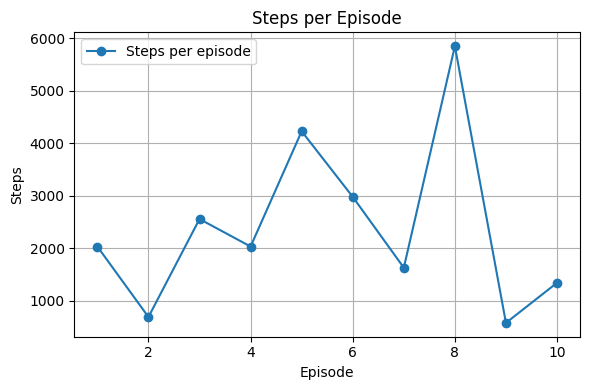

In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Constants
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
goal_position_valley = 3 * math.pi / 6 
force = 0.001
gravity = 0.0025
max_speed = 0.07
start_position = -math.pi / 6
hill_frequency = 3

min_gradient = np.cos(3 * max_position)
max_gradient = np.cos(3 * min_position)

x_threshold = 0.0 #chose 0.0 because the position is in -0.5 and the goal is around 1.5, tried with different thresholds and this was better.

def hill(x):
    return np.sin(hill_frequency * x) * 0.5

num_steps = 20000
episodes = 10
gradient_bins = 60
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002
runs = 0
wrong_hill = -1.5

#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation with colours
Q = np.zeros((len(gradient_bin_edges), 2, len(action_space)))  # (gradient_bins, 2 colors, actions)

#function to get the colour if the agent is in a particular position
def get_colour(position):
    return 0 if position < x_threshold else 1  #green if position is less than 0/x threshold

#data collection for debugging 
data = []
steps_per_episode = []
total_rewards_per_episode = []
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1


def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0


    position = start_position
    velocity = 0.0
    done = False

    while not done:
        gradient = np.cos(3 * position)
         #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 3
        state_g = np.digitize(gradient, gradient_bin_edges) - 1
        colour = get_colour(position) #gets the colour for that position

           #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space)) #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g, colour]) #exploiting
            exp_no += 1

        action = action_space[action_index]


         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - gravity * gradient
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)


         #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0
         #some more reward so that the agent would behave, decreased it as this task has more information than the previous one, should behave
        if action_index > 0:
            reward += 0.001

      #recording data
        data.append({
            "Episode": episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Color": "Green" if colour == 0 else "Red",
            "Action": action,
            "Reward": reward,
            "Q value": Q[state_g, colour, action_index]
        })

        
        #update the gradient
        new_gradient = np.cos(3 * position)
        new_state =np.digitize(new_gradient, gradient_bin_edges) - 1
        new_colour = get_colour(position)

           #update Q learning
        best_future_q = np.max(Q[new_state, new_colour])
        Q[state_g, colour, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, colour, action_index])

       
        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position <= min_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps reached"
            done = True
    print(f"Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}")
    return data_episode, steps_in_episode
    

#run the episodes
for episode in range(episodes):
    episode_data, steps = run_ep(episode, epsilon)
    data.extend(episode_data)
    steps_per_episode.append(steps)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  #exponential decay
    
#convert the data into dataframe for viewing
df = pd.DataFrame(data)
print(df)

#plotting steps per episode for all 10 episodes
plt.figure(figsize=(6, 4))
plt.plot(range(1, episodes + 1), steps_per_episode, marker="o", label="Steps per episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Success in run 1: 6, steps: 22004
Success in run 2: 6, steps: 26317
Success in run 3: 8, steps: 26967
Success in run 4: 6, steps: 30671
Success in run 5: 7, steps: 21291
Success in run 6: 6, steps: 20556
Success in run 7: 6, steps: 20281
Success in run 8: 6, steps: 30574
Success in run 9: 6, steps: 19952
Success in run 10: 6, steps: 21446
Total success:  63
Average step run:  24005.9
[1844.3 2698.1 2397.9 1926.7 3107.5 1916.7 2579.6 1425.4 3242.6 2867.1]


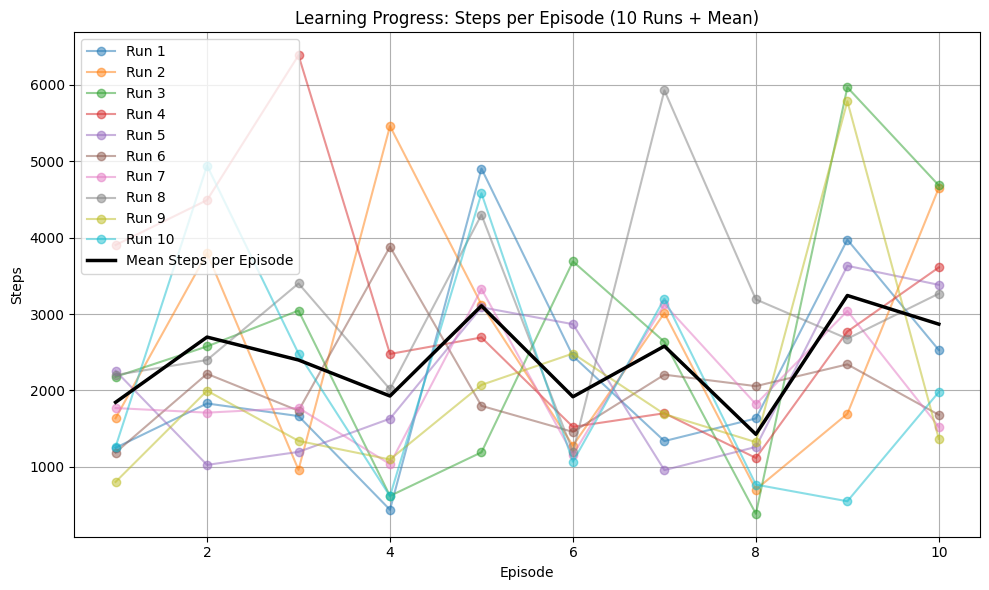

        Run  Episode  Step  Position  Velocity  Color  Action  Reward  \
0         1        1     1 -0.522599  0.001000  Green       1  -0.009   
1         1        1     2 -0.522606 -0.000007  Green      -1  -0.010   
2         1        1     3 -0.521621  0.000985  Green       1  -0.009   
3         1        1     4 -0.521651 -0.000030  Green      -1  -0.010   
4         1        1     5 -0.520695  0.000956  Green       1  -0.009   
...     ...      ...   ...       ...       ...    ...     ...     ...   
240054   10       10  1975 -1.404122 -0.024273  Green      -1  -0.010   
240055   10       10  1976 -1.428197 -0.024075  Green      -1  -0.010   
240056   10       10  1977 -1.452235 -0.024038  Green      -1  -0.010   
240057   10       10  1978 -1.476402 -0.024167  Green      -1  -0.010   
240058   10       10  1979 -1.500000 -0.024468  Green      -1  -5.000   

         Q value  
0       0.000000  
1       0.000000  
2      -0.000900  
3       0.000000  
4       0.000000  
...      

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Constants
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
goal_position_valley = 3 * math.pi / 6 
force = 0.001
gravity = 0.0025
max_speed = 0.07
start_position = -math.pi / 6
hill_frequency = 3

min_gradient = np.cos(3 * max_position)
max_gradient = np.cos(3 * min_position)

x_threshold = 0.0 #chose 0.0 because the position is in -0.5 and the goal is around 1.5, tried with different thresholds and this was better.

def hill(x):
    return np.sin(hill_frequency * x) * 0.5

num_steps = 20000
episodes = 10
gradient_bins = 60
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002
runs = 0
wrong_hill = -1.5

#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation with colours
Q = np.zeros((len(gradient_bin_edges), 2, len(action_space))) 

#function to get the colour if the agent is in a particular position
def get_colour(position):
    return 0 if position < x_threshold else 1  #green if position is less than 0/x threshold

#data collection for debugging 
data = []
steps_per_episode = []
total_rewards_per_episode = []
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1


def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0


    position = start_position
    velocity = 0.0
    done = False

    while not done:
        gradient = np.cos(3 * position)
         #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 3
        state_g = np.digitize(gradient, gradient_bin_edges) - 1
        colour = get_colour(position) #gets the colour for that position

           #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space)) #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g, colour]) #exploiting
            exp_no += 1

        action = action_space[action_index]


         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - gravity * gradient
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)


         #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0
         #some more reward so that the agent would behave, decreased it as this task has more information than the previous one, should behave
        if action_index > 0:
            reward += 0.001

      #recording data
        data.append({
            "Run": run + 1,
            "Episode": episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Colour": "Green" if colour == 0 else "Red",
            "Action": action,
            "Reward": reward,
            "Q value": Q[state_g, colour, action_index]
        })

        
        #update the gradient
        new_gradient = np.cos(3 * position)
        new_state =np.digitize(new_gradient, gradient_bin_edges) - 1
        new_colour = get_colour(position)

           #update Q learning
        best_future_q = np.max(Q[new_state, new_colour])
        Q[state_g, colour, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, colour, action_index])

       
        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position <= min_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps reached"
            done = True
    #Uncomment this to see the runs in more detail
    #print(f'Run {run + 1} Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}')
    return steps_in_episode, success

#Data for plotting for all 10 runs with 10 episodes
steps_per_run = []
total_success = 0
total_run_steps = 0  #to calculate total steps from all runs
for run in range(10): 
    Q = np.zeros((len(gradient_bin_edges), 2,  len(action_space)))
    steps_per_episode = []
    success_per_ep = 0 # successful outcomes per episode
    success_per_run =0  # successful outcomes per run, its data will be used for finding the sum of overall successful outcomes to measure performance
    epsilon = 0.04 # resetting epsilon for each run
    steps_one_run = 0  #collects steps for one run, its data will be used for calculating the average of all runs
    
    for episode in range(episodes):         
        steps, success_no = run_ep(episode, epsilon)        
        steps_per_episode.append(steps)
        success_per_ep += success_no
        steps_one_run += steps
        epsilon = max(epsilon * epsilon_decay, epsilon_min)   #exponential decay per episode

    steps_per_run.append(steps_per_episode)
    success_per_run += success_per_ep #successful outcomes per run
    total_success += success_per_run # total successful outcomes 
    total_run_steps += steps_one_run #total steps from all runs
    print(f"Success in run {run + 1}: {success_per_run}, steps: {steps_one_run}")  #shows all successful outcomes in each run along with steps for each run

average_steps_per_run = total_run_steps / 10  # average steps per run to check performance

#printing data for performance
print("Total success: ", total_success) #shows the sum of all successful outcomes of all 10 runs
print("Average step run: ", average_steps_per_run)


#Calculate the mean steps per episode across all runs
mean_steps = np.mean(steps_per_run, axis=0)
print(mean_steps)


#Plotting all 10 runs and 10 episodes
plt.figure(figsize=(10, 6))
for run_idx, steps in enumerate(steps_per_run):
    plt.plot(range(1, episodes + 1), steps, marker="o", label=f"Run {run_idx + 1}", alpha=0.5)

plt.plot(range(1, episodes + 1), mean_steps, color="black", linewidth=2.5, label='Mean Steps per Episode')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per episode for all 10 runs with mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#printing the dataframe
df = pd.DataFrame(data)
print(df)
